In [70]:
%matplotlib inline
import pandas as pd
import numpy as np
import scipy
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
import pickle
import math

LABEL_COLS  = ['neutral', 'happiness', 'surprise', 'sadness', 'anger', 'disgust', 'fear', 'contempt' ,'unknown', 'NF']
EMOTION_COLS = ['neutral', 'happiness', 'surprise', 'sadness', 'anger', 'disgust', 'fear', 'contempt' ,'unknown']

## Dataset preprocessing functions

In [2]:
def _calc_metrics(series):
    n_annotations = sum(series[EMOTION_COLS])
    if n_annotations==0:
        series['entropy'] = np.nan
        series['disagreement_p'] = np.nan
        return series
    # count -> probabilities. 
    probs = list(series[EMOTION_COLS]*1.0/n_annotations)
    series['entropy'] = scipy.stats.entropy(probs)
    series['disagreement_p'] = 1.0 - sum([p*p for p in probs]) # 1 - \sum p^2 
    return series


def preprocess(df):
    df = df.apply(_calc_metrics, axis=1)
    df = df.dropna(subset=['img_name', 'entropy', 'disagreement_p'])
    return df

## Import FER+ labels

In [3]:
def import_dataset(dataset): #dataset options= Train, Test, Valid
    label_file = 'datasets/FER+/FERPlus/data/FER2013' + dataset + '/label.csv'
    inp = pd.read_csv(label_file, header=None)
    inp.columns = ['img_name', 'shape'] + LABEL_COLS
    labels = preprocess(inp)
    print (f'{dataset} size: {len(labels)}')
    return labels
    
    
train_df = import_dataset('Train')

Train size: 28556


## Explore distribution of subjectivity

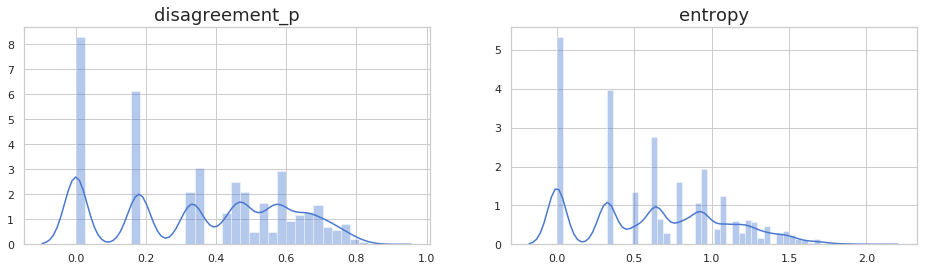

In [4]:
def _plot_subhist(inp, val, axis):
    sns.distplot(list(inp[val]), ax=axis).set_title(val,fontsize=18)


def plot_hist(inp):
    sns.set(style="whitegrid", palette="muted", color_codes=True)
    f, axes = plt.subplots(1,2, figsize=(16, 4))
    _plot_subhist(inp, 'disagreement_p', axes[0])
    _plot_subhist(inp, 'entropy', axes[1])
        
plot_hist(train_df)

## Import raw images

In [5]:
fer = pd.read_csv('datasets/FER+/FER/fer2013/fer2013.csv')
ferplus = pd.read_csv('datasets/FER+/FERPlus/fer2013new.csv')
all_df = fer.merge(ferplus, how='inner', on ='Usage', left_index=True, right_index=True)
all_df = all_df.rename(columns={"Usage": "dataset", "Image name": "img_name"})
all_df = preprocess(all_df)

## Visual exploration of extreme cases

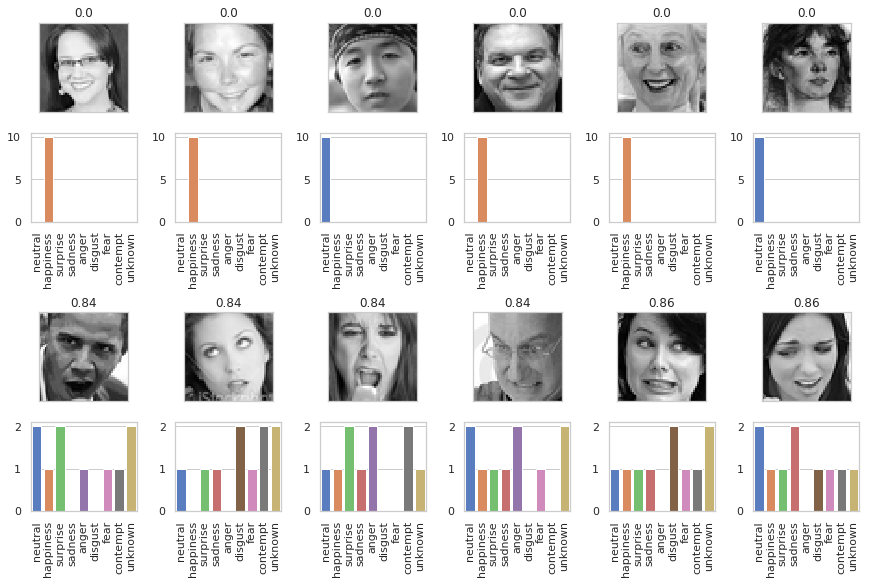

In [6]:
def _plot_img_hist(inp, axes, ax_i, ax_j):
    img_ax = axes[ax_i, ax_j]
    hist_ax = axes[ax_i+1, ax_j]
    
    NEW_SHAPE = (48, 48)
    img_arr = np.array([int(i) for i in inp['pixels'].split(' ')])
    img_arr = np.reshape(img_arr, NEW_SHAPE)
    img_ax.set_title(inp["disagreement_p"])
    img_ax.imshow(img_arr, cmap='gray')
    img_ax.set_xticks([])
    img_ax.set_yticks([])
    
    sns.barplot(np.arange(len(EMOTION_COLS)), list(inp[EMOTION_COLS]), ax=hist_ax)
    hist_ax.set_xticklabels(EMOTION_COLS, rotation='vertical')


# Show n images with highest disagreement and n images with lowest disagreement probability
def show_extreme_cases(inp, n):
    inp = inp.sort_values(by=['disagreement_p', 'entropy'])
    f, axes = plt.subplots(4, n, figsize=(n*2, 8), constrained_layout=True)
    for i in range(n):
        _plot_img_hist(inp.iloc[i], axes, 0, i)
    for i in range(n):
        _plot_img_hist(inp.iloc[len(inp)-1-i], axes, 2, n-i-1)
        
all_train_df = all_df[all_df['dataset']=='Training'].reset_index(drop=True)
show_extreme_cases(all_train_df, 6)

## Do images with similar embeddings look similar?

In [160]:
def _key(inp):
    # Euclidian distance, then cosine similiraty
    return (inp[2], inp[3])

embeddings = pickle.load(open('datasets/FER+/embedding/embeddings.pkl', 'rb'))
N = 1000
# N = len(embeddings)
distances = [[i, j, 
                  distance(embeddings[i], embeddings[j], distance_metric=0), 
                  distance(embeddings[i], embeddings[j], distance_metric=1)
             ] for i in range(N) for j in range(i+1, N)]

distances.sort(key=_key)

/mas/u/asma_gh/venvs/uncnet/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in arccos


/mas/u/asma_gh/venvs/uncnet/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in arccos


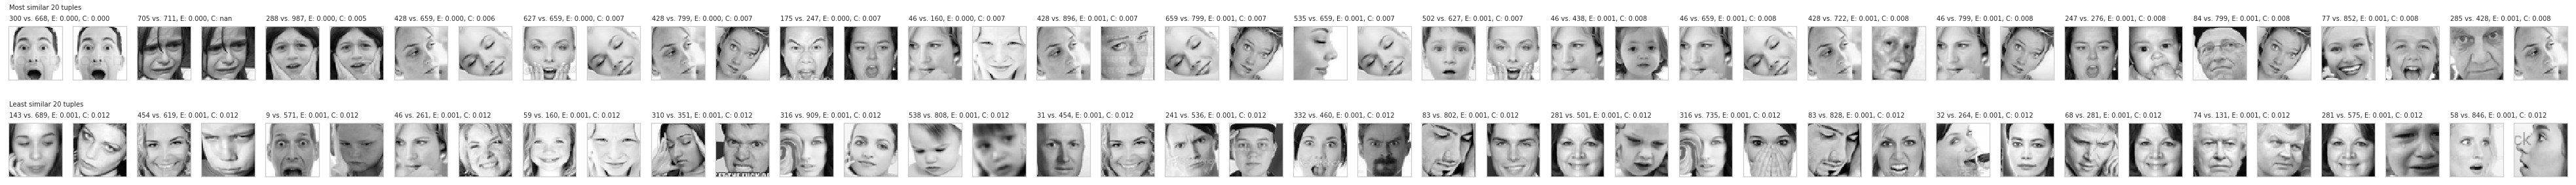

In [198]:
def _plot_img(inp, axis):
    NEW_SHAPE = (48, 48)
    img_arr = np.array([int(i) for i in inp['pixels'].split(' ')])
    img_arr = np.reshape(img_arr, NEW_SHAPE)
    axis.imshow(img_arr, cmap='gray')
    axis.set_xticks([])
    axis.set_yticks([])
    
def distance(embeddings1, embeddings2, distance_metric=0):
    if distance_metric==0:
        # Euclidian distance
        diff = np.subtract(embeddings1, embeddings2)
        dist = np.sum(np.square(diff))
    elif distance_metric==1:
        # Distance based on cosine similarity
        dot = np.sum(np.multiply(embeddings1, embeddings2))
        norm = np.linalg.norm(embeddings1) * np.linalg.norm(embeddings2)
        similarity = dot / norm
        dist = np.arccos(similarity) / math.pi
    else:
        print(f'Undefined distance metric {distance_metric}')
        return np.nan
    return dist

def plot_comparisons(all_df, embeddings, i, j, axes, ax_i, ax_j):
#     f, axes = plt.subplots(1, 2, figsize=(3, 2), constrained_layout=True)
    _plot_img(all_df.iloc[i], axes[ax_i][2*ax_j])
    _plot_img(all_df.iloc[j], axes[ax_i][2*ax_j+1])
    axes[ax_i][2*ax_j].text(0, -5, '{0} vs. {1}, E: {2:.3f}, C: {3:.3f}'.format(
        i, j, distance(embeddings[i], embeddings[j], 0), distance(embeddings[i], embeddings[j], 1)))

def find_extreme_cases(distances, n):
    f, axes = plt.subplots(2, 2*n, figsize=(3.5*n, 5)) #, constrained_layout=True
    axes[0][0].text(0, -15, f'Most similar {n} tuples')
    axes[1][0].text(0, -15, f'Least similar {n} tuples')
    for top_idx in range(n):
        i = distances[top_idx][0]
        j = distances[top_idx][1]
        plot_comparisons(all_df, embeddings, i, j, axes, 0, top_idx)
    
    for top_idx in range(n):
        bottom_idx = N-top_idx-1
        i = distances[bottom_idx][0]
        j = distances[bottom_idx][1]
        plot_comparisons(all_df, embeddings, i, j, axes, 1, top_idx)
    plt.show()


find_extreme_cases(distances, 20)